# Normalizing Dual Luciferase Assay System

**Dual Luciferase Assay System** produces 2 signals. One of them (Luc) is the signal of interest like the response of the cell to an odorant, and the other one (RL) is only a mean to normalize the first signal to, and it supposed to capture parameters like the  transfection efficiency. 

In this notebook, we show that we are better off without the normalization signal RL, at least in the data of Human olfactory system. Probably the reading of RL is noisier than variation of transfection efficiency and cell 

We propose another way to normalize data of plates to consider the variability among trials.


In [1]:
# Loading libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 6, 3
plt.rcParams['figure.dpi'] = 150

The experiment has 3 parts. The first part is called *primary* through out the article and its data are in PrimaryScreen.tsv.

The name of Odorant Receptors (OR) are in Receptors.tsv, we join the two tables and print out few of its lines too check the data.

In [2]:
primary = pd.read_table('../data/PrimaryScreen.tsv')
OR = pd.read_table('../data/Receptors.tsv', index_col='OR')

odor = pd.read_table('../data/Odors.tsv', index_col='Odor')
odor.loc[9999,'OdorName'] = 'no odor'  # 9999 means there is no odorant

primary = primary.join(OR[['Gene']], on="OR")
primary = primary.join(odor[['OdorName']], on="Odor")

test_or = 'Olfr544' 

primary.dropna(inplace=True) #removing missing data

primary['log_Luc'] = np.log(primary.Luc)
primary['log_RL'] = np.log(primary.RL)
primary['log_normalized'] = np.log(primary.Luc/primary.RL)
primary['normalized_log'] = primary.log_Luc/primary.log_RL

print(primary.shape)
primary.head()

(50016, 14)


,Plate,Well,Concentration,Luc,RL,OR,Odor,Date,Gene,OdorName,log_Luc,log_RL,log_normalized,normalized_log
0,1,1,100.0,3516.0,10770.0,1024.0,1116.0,61009,OR10K1,Cyclohexanone,8.165079,9.284520,-1.119441,0.879429
1,1,2,100.0,3264.0,10126.0,1032.0,1116.0,61009,OR10T2,Cyclohexanone,8.090709,9.222862,-1.132153,0.877245
2,1,3,100.0,3598.0,10664.0,1040.0,1116.0,61009,OR10K2,Cyclohexanone,8.188133,9.274629,-1.086495,0.882853
3,1,4,100.0,1624.0,7524.0,1049.0,1116.0,61009,OR2T34,Cyclohexanone,7.392648,8.925853,-1.533206,0.828229
4,1,5,100.0,2198.0,15474.0,1057.0,1116.0,61009,OR2V2 H221R,Cyclohexanone,7.695303,9.646916,-1.951613,0.797696


![](https://images.nature.com/w926/nature-assets/sdata/2015/sdata20152/images_hires/sdata20152-f4.jpg)

A plate has 96 well in which 6 of them (green wells) were assigned to *Olfr544* receptor. 3 out of 6 were challenged with its ligand *nonanedioic acid* and the other three remained odorless (dark and light shades of green respectively). The data about this pair is abundant, so we focus on this pair to investigate the limits of the technique. Here we select *Olfr544* wells:

In [3]:
test = primary[primary.Gene == test_or].copy()

In [4]:
test.Concentration.value_counts()

0.0     1626
10.0    1374
1.0      252
Name: Concentration, dtype: int64

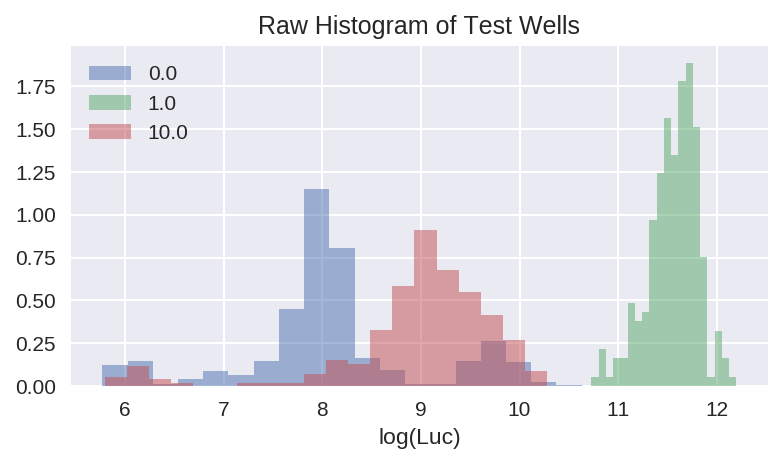

In [5]:
g = test.groupby('Concentration')
g.log_Luc.hist(bins=20, normed=True, alpha=0.5)
plt.legend(g.groups.keys());
plt.title('Raw Histogram of Test Wells')
plt.xlabel("log(Luc)")
plt.savefig('../fig/raw_histogram.pdf', frameon=True)

There are two inconsistency in the data. First, the Luc signal of *Olfr544* challenged by 1 μM of *nonanedioic acid* is far more than those challenged by 10 μM. There is also a second peak at the zero concentration. Lets remove the data of  1 μM and see what happens.

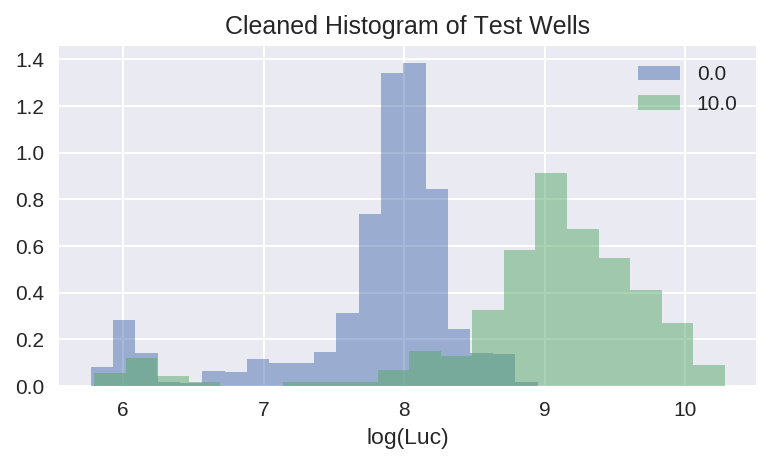

In [6]:
test['c_is_1'] = (test.Concentration == 1)
tmp = pd.DataFrame(test.groupby(['Date', 'Plate']).c_is_1.max())
tmp.columns=['has_c_1']
#test.drop('c_is_1', axis=1, inplace=True)
primary = primary.join(tmp, on=['Date','Plate'])

test = primary[(~primary.has_c_1) & (primary.Gene == test_or)].copy()

g = test.groupby('Concentration')
g.log_Luc.hist(bins=20, normed=True, alpha=0.5)
plt.legend(g.groups.keys());
plt.title('Cleaned Histogram of Test Wells')
plt.xlabel("log(Luc)")
plt.savefig('../fig/cleaned_histogram.pdf')

Now the data looks more consistent. The second peak at zero concentration is also gone. There is a small overlap between baseline (zero concentration of odorant) and the signal (10 μM). We hope that normalizing Luc by RL improves that (Luc/RL). 

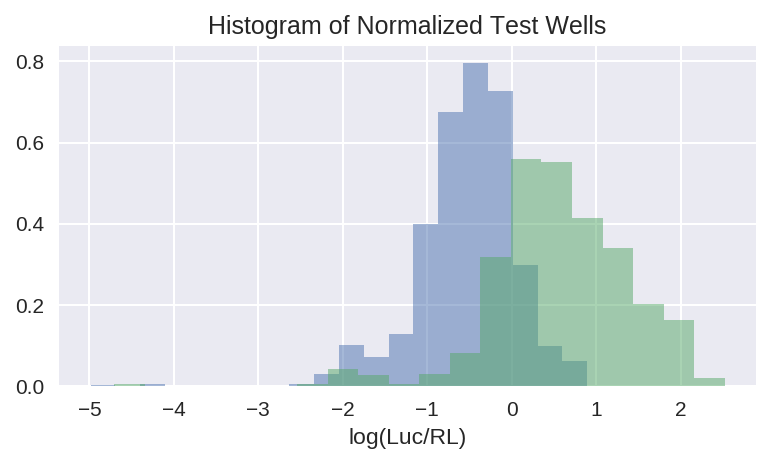

In [7]:
g.log_normalized.hist(bins=20, normed=True, alpha=0.5)
plt.title('Histogram of Normalized Test Wells')
plt.xlabel("log(Luc/RL)")
plt.savefig('../fig/normalized_histogram.pdf')

The act of normalization increased the overlap of baseline and signal, the normalization has degregaded the signal. This is strange. Let look at correlations.

In [8]:
test.loc[test.Concentration == 0,['Luc', 'RL']].corr(method='spearman')

,Luc,RL
Luc,1.000000,0.406954
RL,0.406954,1.000000


In [9]:
test.loc[test.Concentration == 10,['Luc', 'RL']].corr(method='spearman')

,Luc,RL
Luc,1.000000,0.088009
RL,0.088009,1.000000


There is a correlation between Luc and RL at the baseline. But for the signal, the correlation is very small and it might be statistically insignificant (I should do a test, let do it later). 

## A classifier to discriminate between baseline and signal

I train a simple Gaussian Naive Bayes classifier on different subset of features and monitor the performance using 5 fold cross validation. 

In [10]:
# Load the classifiers

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [11]:
# Naive Bayes on log(Luc/R)

clf = GaussianNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

m = cross_val_score(clf, test[['log_normalized']], test.Concentration, cv=cv, scoring='accuracy')
print(m.mean(), m.std())

0.826792302588 0.00681552440476


In [12]:
# Naive Bayes on log(Luc)

clf = GaussianNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

m = cross_val_score(clf, test[['log_Luc']], test.Concentration, cv=cv, scoring='accuracy')
print(m.mean(), m.std())

0.908662242867 0.00262176366864


In [13]:
# Naive Bayes on log(Luc) and log(R) together. 

clf = GaussianNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

m = cross_val_score(clf, test[['log_Luc', 'log_RL']], test.Concentration, cv=cv, scoring='accuracy')
print(m.mean(), m.std())

0.903566025216 0.00474332465858


The accuracy on the normalized signal is about 0.83 which is not bad. But when we use the logarithm of the raw signal, the accuracy improves to about 0.91. Adding logarithm of RL as a separate feature, have no significant effect.

## RL is irrelevant!

RL is irrelevant, we are better of to use another method to account for the variabilities in the experiment. 
We calculate average of Luc and RL in each plate and for each concentration (0, and 10):

In [14]:
cor = test[['Date', 'Plate', 'Concentration', 'Luc', 'RL']].groupby(['Date', 'Plate', 'Concentration']).mean().unstack().corr(method='spearman')
print(cor.to_latex())

\begin{tabular}{llrrrr}
\toprule
    &      &       Luc &           &        RL &           \\
    &      &      0.0  &      10.0 &      0.0  &      10.0 \\
{} & Concentration &           &           &           &           \\
\midrule
Luc & 0.0  &  1.000000 &  0.526706 &  0.409388 &  0.356017 \\
    & 10.0 &  0.526706 &  1.000000 & -0.004543 &  0.070109 \\
RL & 0.0  &  0.409388 & -0.004543 &  1.000000 &  0.878681 \\
    & 10.0 &  0.356017 &  0.070109 &  0.878681 &  1.000000 \\
\bottomrule
\end{tabular}



Luc at c = 10 is best correlated with Luc at c = 0. The correlation between Luc at c = 10 and RLs is negligible.
We suggest to use the average of Luc of baseline test wells to normalize the whole plate. 

In [15]:
tmp = test[['Date', 'Plate', 'Concentration', 'Luc']].groupby(['Date', 'Plate', 'Concentration']).mean().unstack()
#np.log(tmp.Luc).hist()
((tmp.Luc[10]/tmp.Luc[0])).min()
primary = primary.join(tmp, on=['Date','Plate'])

primary['Luc_0'] = primary[('Luc',0)]
primary['Luc_10'] = primary[('Luc',10)]

/usr/lib/python3/dist-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [16]:
tmp.head()

Luc              
Concentration         0.0           10.0
Date  Plate                             
61009 1        5516.666667  22742.000000
      2        6878.000000  23708.666667
      3        6052.000000  22227.333333
      4        6392.666667  21615.333333
      5        6697.333333  21426.000000

Let us fine a receptor to test our idea on:

In [17]:
primary.Gene.value_counts().head()

pseudo      3708
Olfr544     3252
Olfr1341     458
Olfr73       458
OR2T5        300
Name: Gene, dtype: int64

In [18]:
primary[primary.Gene == 'Olfr1341'].OdorName.value_counts().head()

no odor           38
heptaldehyde      13
eugenol           11
r-limonene        11
ethyl vanillin    11
Name: OdorName, dtype: int64

second most used receptors are *Olfr1341* and *Olfr73*. 

In [19]:
primary[primary.Gene == 'Olfr73'].OdorName.value_counts().head()

no odor           38
heptaldehyde      13
eugenol           11
r-limonene        11
ethyl vanillin    11
Name: OdorName, dtype: int64

In [20]:
primary[primary.Gene == 'OR2T5'].OdorName.value_counts().head()

no odor           25
heptaldehyde      10
ethyl vanillin     8
r-limonene         8
eugenol            8
Name: OdorName, dtype: int64

For the two receptor we have 38 baseline reading and 13 response to heptaldehyde.

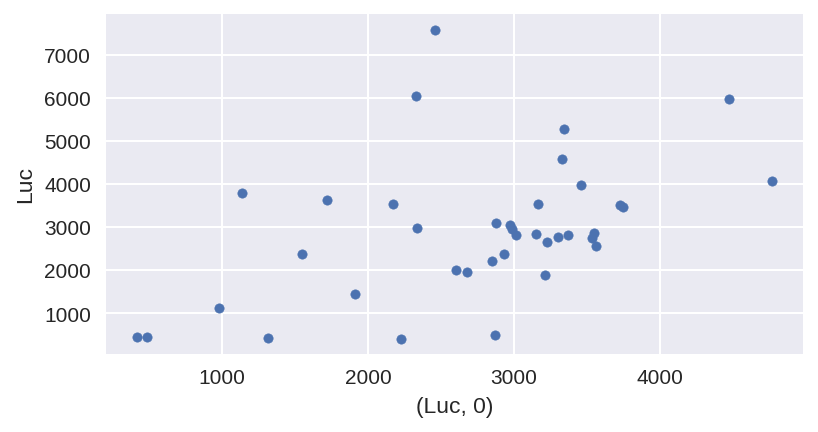

In [21]:
primary[(primary.OdorName == 'no odor') & (primary.Gene == 'Olfr1341') & (~primary.has_c_1)].plot(kind='scatter', x=('Luc',0), y='Luc');

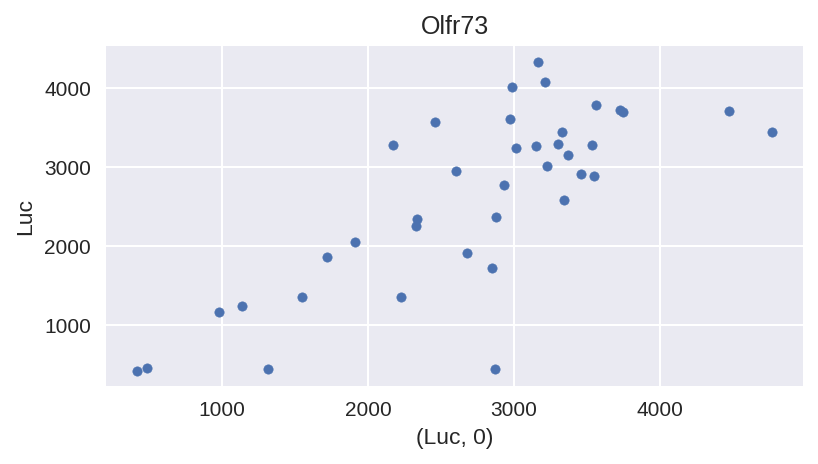

In [22]:
primary[(primary.OdorName == 'no odor') & (primary.Gene == 'Olfr73') & (~primary.has_c_1)].plot(kind='scatter', x=('Luc',0), y='Luc');
plt.title('Olfr73')
plt.savefig('../fig/Olfr73.pdf')

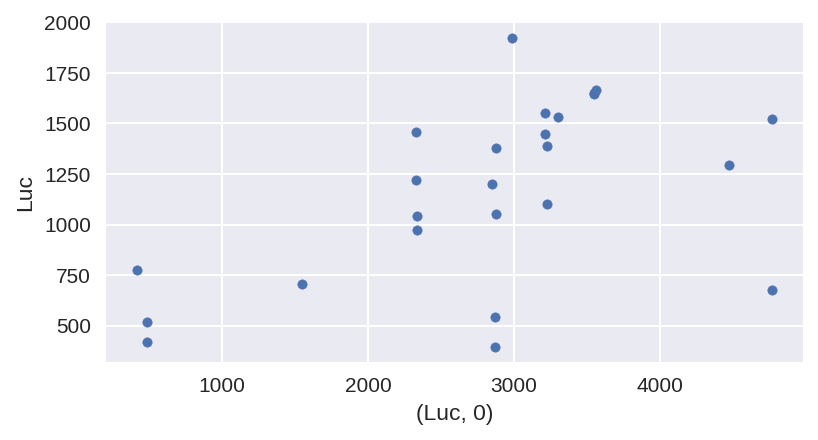

In [23]:
primary[(primary.OdorName == 'no odor') & (primary.Gene == 'OR2T5') & (~primary.has_c_1)].plot(kind='scatter', x=('Luc',0), y='Luc');

## Correlations
Correlation among Luc, RL and mean Luc of baseline (Luc_0) and signal (Luc_10) test wells on the same plate. 

In [24]:
# Olfr1341 and no odor
primary.loc[(primary.OdorName == 'no odor') & (primary.Gene == 'Olfr1341') & (~primary.has_c_1), ['Luc', 'RL', 'Luc_0', 'Luc_10']].corr()

,Luc,RL,Luc_0,Luc_10
Luc,1.000000,-0.109871,0.454975,0.381440
RL,-0.109871,1.000000,-0.121185,-0.243047
Luc_0,0.454975,-0.121185,1.000000,0.561889
Luc_10,0.381440,-0.243047,0.561889,1.000000


In [25]:
# Olfr73 and no odor
primary.loc[(primary.OdorName == 'no odor') & (primary.Gene == 'Olfr73') & (~primary.has_c_1), ['Luc', 'RL', 'Luc_0', 'Luc_10']].corr()

,Luc,RL,Luc_0,Luc_10
Luc,1.000000,-0.098649,0.773972,0.333297
RL,-0.098649,1.000000,-0.141776,-0.315375
Luc_0,0.773972,-0.141776,1.000000,0.561889
Luc_10,0.333297,-0.315375,0.561889,1.000000


In [26]:
# OR2T5 and no odor
primary.loc[(primary.OdorName == 'no odor') & (primary.Gene == 'OR2T5') & (~primary.has_c_1), ['Luc', 'RL', 'Luc_0', 'Luc_10']].corr()

,Luc,RL,Luc_0,Luc_10
Luc,1.000000,0.478491,0.522445,0.159496
RL,0.478491,1.000000,0.044840,-0.241016
Luc_0,0.522445,0.044840,1.000000,0.695992
Luc_10,0.159496,-0.241016,0.695992,1.000000


In [27]:
# Olfr1341 and heptaldehyde
primary.loc[(primary.OdorName == 'heptaldehyde') & (primary.Gene == 'Olfr1341') & (~primary.has_c_1), ['Luc', 'RL', 'Luc_0', 'Luc_10']].corr()

,Luc,RL,Luc_0,Luc_10
Luc,1.000000,0.746641,0.646273,0.609538
RL,0.746641,1.000000,0.716677,0.441725
Luc_0,0.646273,0.716677,1.000000,0.675458
Luc_10,0.609538,0.441725,0.675458,1.000000


In [28]:
# Olfr73 and heptaldehyde
primary.loc[(primary.OdorName == 'heptaldehyde') & (primary.Gene == 'Olfr73') & (~primary.has_c_1), ['Luc', 'RL', 'Luc_0', 'Luc_10']].corr()

,Luc,RL,Luc_0,Luc_10
Luc,1.000000,0.627169,0.819097,0.648033
RL,0.627169,1.000000,0.565652,0.211296
Luc_0,0.819097,0.565652,1.000000,0.675458
Luc_10,0.648033,0.211296,0.675458,1.000000


In [29]:
# OR2T5 and heptaldehyde
primary.loc[(primary.OdorName == 'heptaldehyde') & (primary.Gene == 'OR2T5') & (~primary.has_c_1), ['Luc', 'RL', 'Luc_0', 'Luc_10']].corr()

,Luc,RL,Luc_0,Luc_10
Luc,1.000000,0.550199,0.363380,0.230021
RL,0.550199,1.000000,0.129989,-0.126565
Luc_0,0.363380,0.129989,1.000000,0.914538
Luc_10,0.230021,-0.126565,0.914538,1.000000


In [30]:
primary.to_csv('../data/PrimaryScreen_cleaned.tsv', sep='\t', index = False)

## Conclusion

For both receptors the correlation between Luc and RL of the same well can vary from -0.1 to 0.74.
But the correlation between Luc of that well and the average Luc of baseline test wells on the same plate is in the range of 0.45 to 0.81. 
Therefore we suggest that for the given data, plates should be normalized by the mean of baseline test well.

Further experimental investigation is recommended. 